In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.utils.circuit_factory import CircuitFactory
from exp_a4 import A4Factory
from exp_a23 import A23Factory
from exp_a1 import A1Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct
from qiskit import IBMQ
from qiskit import BasicAer
# import FTSDFactory

In [2]:
class FTSDFactory(CircuitFactory):
    """
    When no time is provided the simulation runs for t=1. The target qubit is the less significant one.
    """
    def __init__(self, num_target_qubits=1):
        super().__init__(num_target_qubits)

    def required_ancillas(self):
        return 0

    def required_ancillas_controlled(self):
        return 0
    
    def build(self, qc, q, q_ancillas=None, params=1):
        pass
        # qc.u3(params, -np.pi/2, np.pi/2, q[0])

    def build_controlled(self, qc, q, q_control, q_ancillas=None, t=1, kj=1, coefficient = [], matrix_index = []):
        if len(coefficient) != len(matrix_index):
            exit("Error.")
        a1 = A1Factory(n)
        a23 = A23Factory(n)
        a4 = A4Factory(n)
        M = len(matrix_index)
        doU1 = True #Sentence to control the order of Trotter sequence
        
        if doU1== True:
            for j in range(kj):
                for i in range(len(matrix_index)):
                    if matrix_index[i]==0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/M/kj)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/M/kj)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/M/kj)
                    else:
                        exit("Wrong matrix index: ", i)
        else:
            for j in range(kj):
                for i in range(len(matrix_index)):
                    if matrix_index[i]==0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    else:
                        exit("Wrong matrix index: ", i)
                for i in reversed(range(len(matrix_index))):
                    if matrix_index[i]==0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/(2*M)/kj)
                    else:
                        exit("Wrong matrix index: ", i)

    def build_inverse(self, qc, q, q_ancillas=None, params=1):
        pass
        # self.build(qc, q, q_ancillas, -params)

    def build_controlled_inverse(self, qc, q, q_control, q_ancillas=None, params=1):
        pass
        #self.build_controlled(qc, q, q_control, q_ancillas, -params)

In [3]:
def uni_matrix_factory(last_column):
    size = np.size(last_column)
    col = last_column.reshape((size, 1))
    a = np.zeros((size, size))

    a[:, [-1]] = col
    for i in range(size-1):
        a[:i+1, [i]] = col[:i+1]
        a[i+1, i] = - sum(col[:i+1]**2) / col[i+1]

    for i in range(size):
        a[:, i] = a[:, i] / np.sqrt(sum(a[:, i]**2))

    a = np.fliplr(a)

    if not check_power_of_a(a.shape[0], 2):
        b = np.zeros((2**n_sum, 2**n_sum))
        b[:size, :size] = a
        a = b
    
    for i in range(size, int(2**np.ceil(np.log2(size)))):
        a[i, i] = 1.
    
    a[np.isnan(a)] = 1

    return a

In [4]:
def check_power_of_a(n, a):
    if n == 1:
        return True
    elif n % a == 0:
        n = n / a
        check_power_of_a(n, a)
    else:
        return False

In [5]:
def dec2bin(decimal_number):
    binlist = []
    for i in range(len(bin(decimal_number))-2):
        binlist.append(int(bin(decimal_number)[2+i]))
    return binlist

def permutation_control(qc, q_control_list, i):
    binlist = dec2bin(i)
    for j in range(len(binlist)):
        if binlist[j]==1:
            qc.x(q_control_list[len(binlist)-j-1])

In [6]:
def put_mct(qc, qr_sum, qrac, n_toff, qrt=None):
    if n_toff > 0:
        qc.mct(qr_sum, qrac[0], qrt)
    elif n_sum == 2:
        qc.ccx(qr_sum[0], qr_sum[1], qrac)
    else:
        qc.cx(qr_sum[0], qrac)

In [7]:
# Need to optimize when the size of k is large (this function uses double loop.)
# arxiv:1907.11679 eq.5
# return: aj: list
def get_aj_from_kj(k):
    m = len(k)
    ret = []
    for j in range(m):
        if k[j] == 0.:
            ret.append(0)
        else:
            aj = 1.
            for q in range(m):
                if j == q: continue;
                aj *= 1 - np.square(k[q] / k[j])
            ret.append(1 / aj)
    return ret;

def fill_zeros(k_vec):
    for i in range(100):
        if len(k_vec) == 2**i:
            return k_vec
        elif len(k_vec) > 2**i:
            continue
        elif i==99:
            exit("Something strange")
        else:
            for j in range(len(k_vec), 2**i):
                k_vec.append(0)
            break
    print(k_vec)
    return k_vec

In [8]:
n=2
t=1
m_list = []
m = 8 #The order of accuracy
m_list.append(m)

#     m = m_input
k_vec = [1, 2, 3, 4, 5, 6, 12, 45]
#for i in range(m):
#   k_vec.append(1+i)
#print(k_vec)
n_sum = int(np.ceil(np.log2(len(k_vec))))

# number of ancilla qubits for the unitary operations themselves
n_ancilla = n-1

# number of ancilla qubits for controlling the unitary operations
n_a_con = 1

# number of ancilla qubits for multi-controlled toffoli
n_toff = n_sum-2

# Hamiltonian setting
matrix_index = [1, 1, 2]  # 0:a1, 1:a23, 2:a4
coefficient = [np.pi/8, np.pi/8, np.pi/8]  # params(e.g. theta) of each matrix

[-1.14254067e-11  4.78722469e-07 -1.45288584e-04  4.60263909e-03
 -3.21230956e-02  5.48345772e-02 -1.53521824e-01  1.12635251e+00]


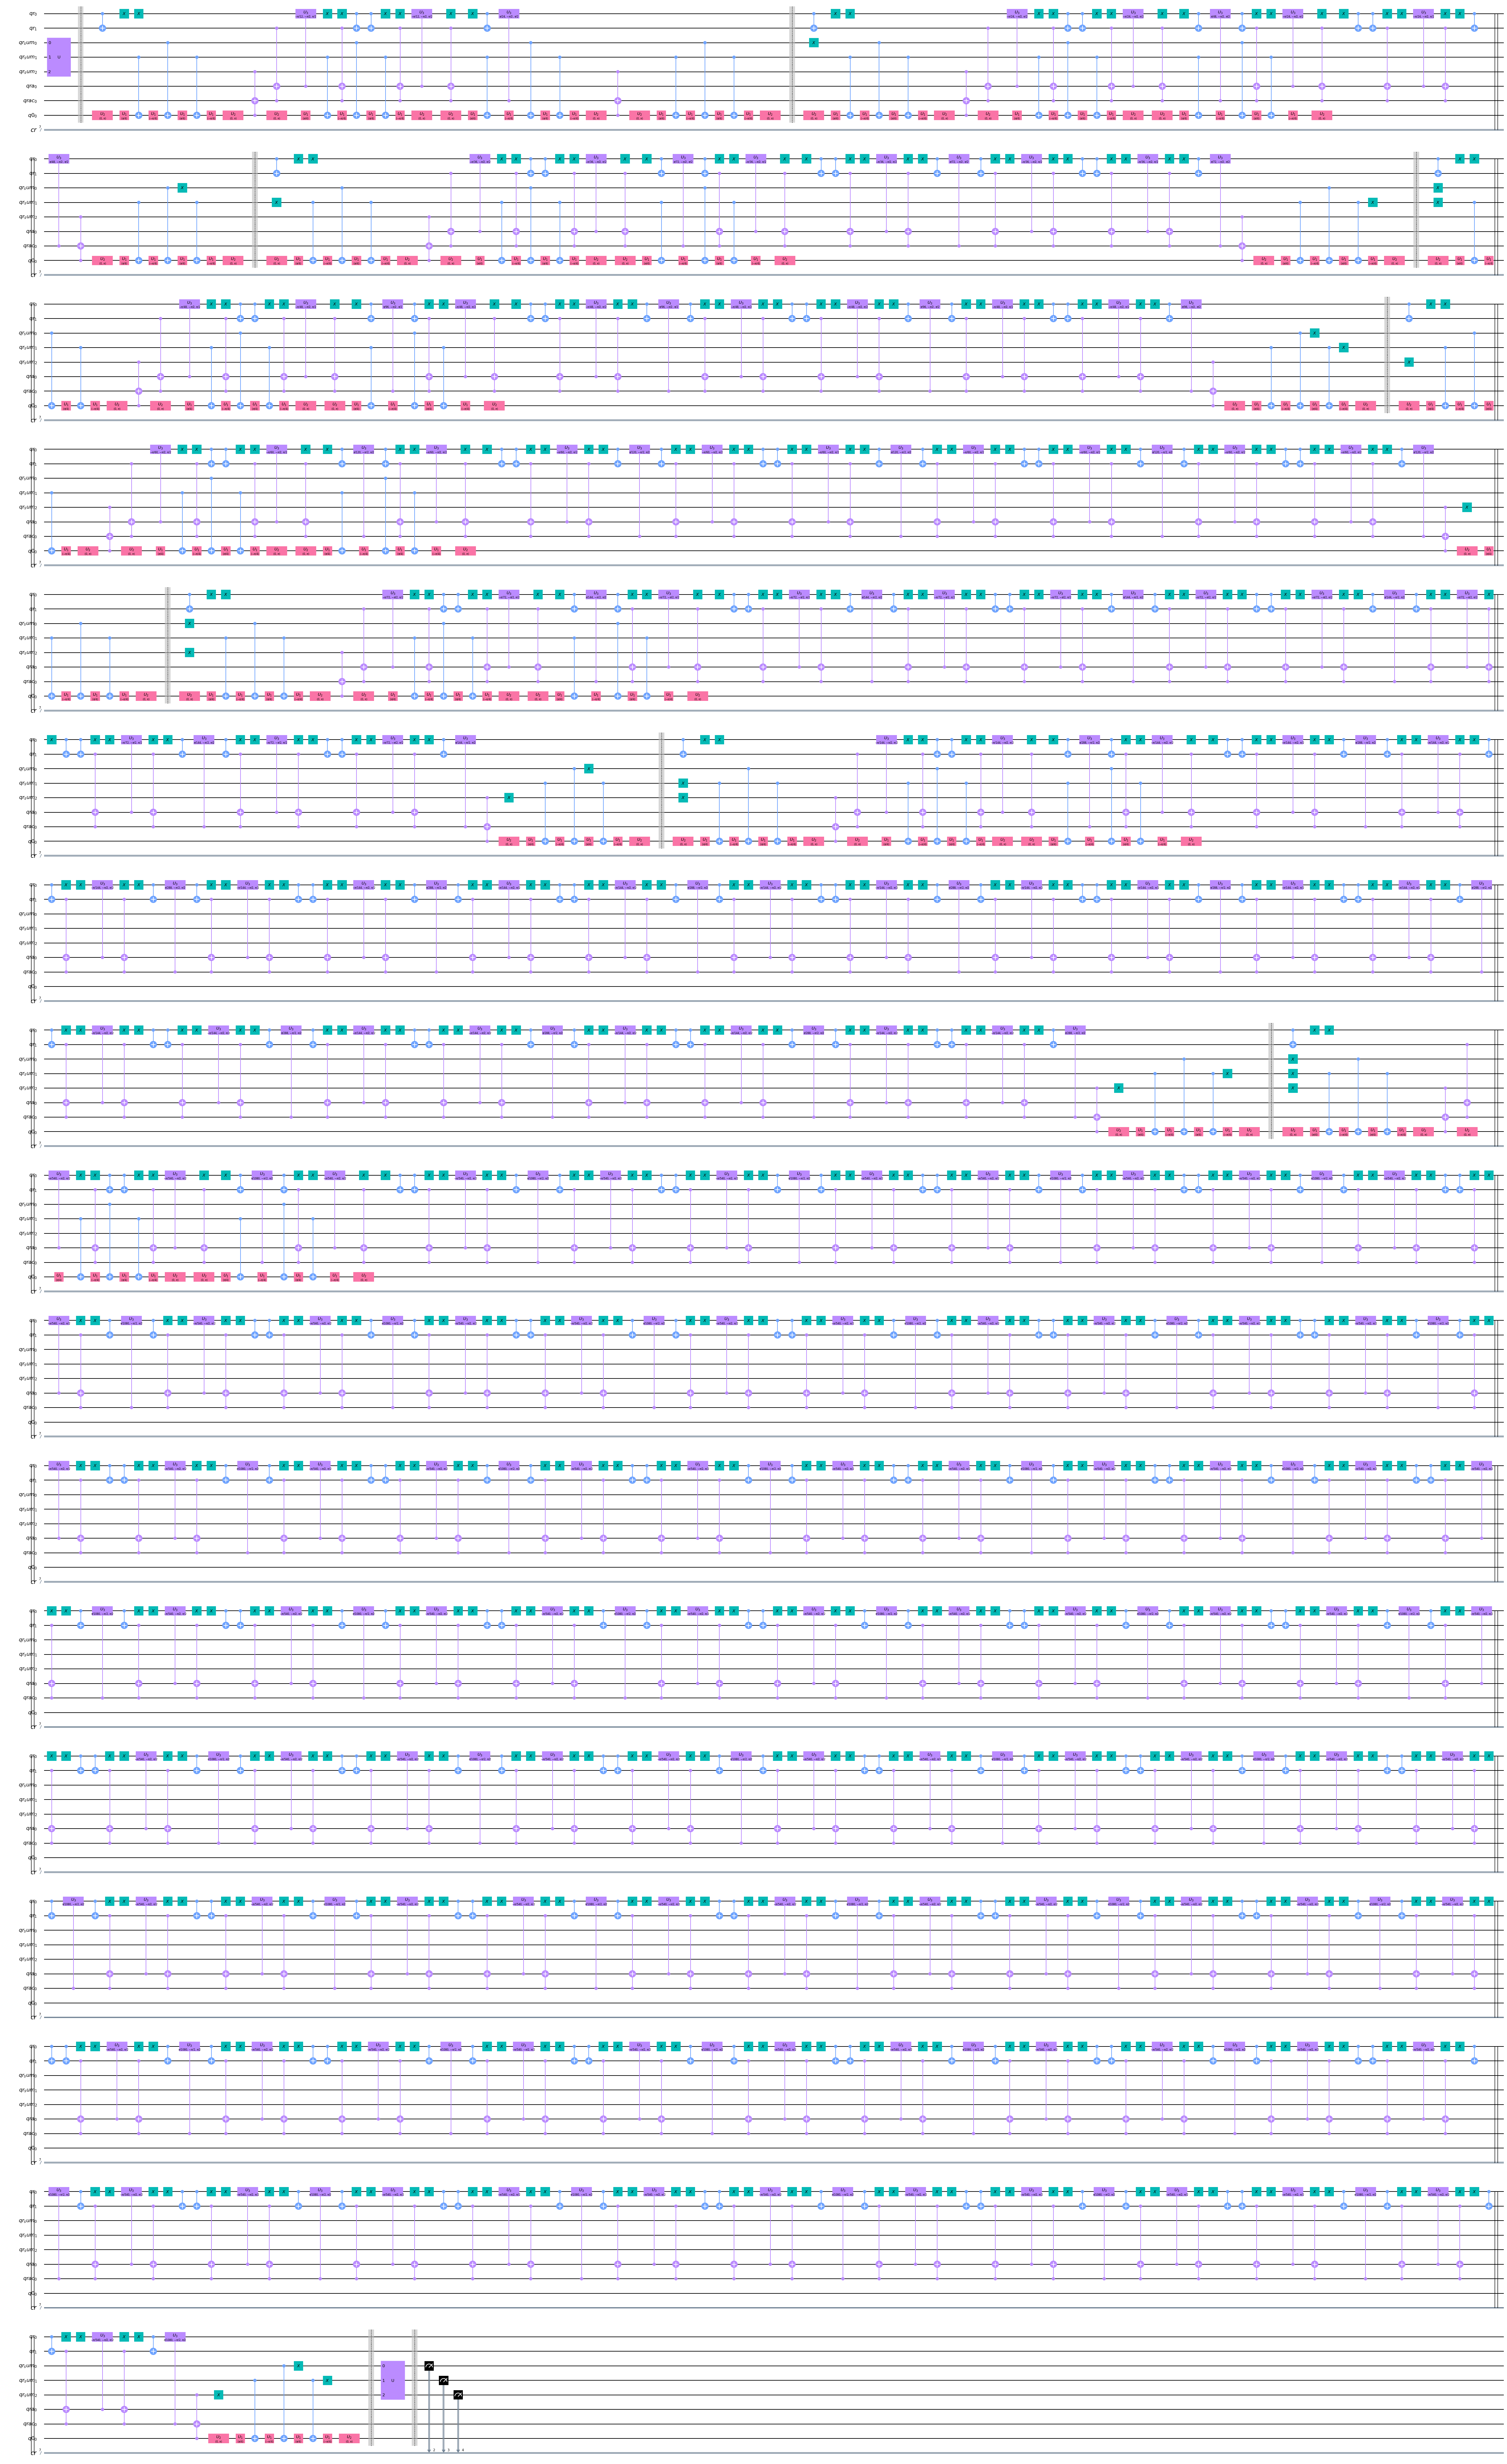

In [9]:
# TODO: for sums with more than 2 elements need to change qr[n] by the right index
#quantum register for the matrix
qr = QuantumRegister(n, 'qr')
qr_sum = QuantumRegister(n_sum, 'qr_sum')
#ancilla qubits
qra = QuantumRegister(n_ancilla, 'qra') if n_ancilla != 0 else QuantumRegister(1, 'qra')
qrac = QuantumRegister(n_a_con, 'qrac')
cr = ClassicalRegister(n+n_sum+n_ancilla+n_a_con, 'cr')
    
if n_toff > 0:
    qrt = QuantumRegister(n_toff)
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, qrt, cr)
else:
    qc = QuantumCircuit(qr, qr_sum, qra, qrac, cr)

#create unitary operations given its last column {a_j}

#k_vec = fill_zeros(k_vec)
a_vector = get_aj_from_kj(k_vec)
a_vector = np.array(a_vector)
print(a_vector)
#a_vector =  np.arange(1, 2**n_sum+1)# a_vector has to be a power of 2
mat_A = uni_matrix_factory(a_vector)
op_A = Operator(mat_A)
op_B = Operator(mat_A.transpose())

# encode coefficient information through A matrix
qc.append(op_A, qr_sum)
qc.barrier()

for i_kj in range(len(k_vec)):
#for i in range(2**n_sum):
    permutation_control(qc, qr_sum, i_kj)
    if n_toff > 0:
        put_mct(qc, qr_sum, qrac, n_toff, qrt)
    else:
        put_mct(qc, qr_sum, qrac, n_toff)
    FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=1, kj=k_vec[i_kj], coefficient=coefficient, matrix_index=matrix_index)
# FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=1, kj=k_vec[i_kj], coefficient=coefficient, matrix_index=matrix_index[1])
    if n_toff > 0:
        put_mct(qc, qr_sum, qrac, n_toff, qrt)
    else:
        put_mct(qc, qr_sum, qrac, n_toff)
    permutation_control(qc, qr_sum, i_kj)
    qc.barrier()

# invert A matrix
qc.append(op_B, qr_sum)

qc.barrier()
# measurement of qr and qr_sum
#     qc.measure(qra, cr[0:n_ancilla])
#     qc.measure(qrac, cr[0:n_a_con])
qc.measure(qr_sum, cr[n:n+n_sum])
qc.draw(output='mpl', fold=100)

In [10]:
# Obtain vector from the circuit
backend = BasicAer.get_backend('statevector_simulator')
# Create a Quantum Program for execution 
job = execute(qc, backend)
# and store the result
result = job.result()
# Remember its an...a0qn..q0, where the a's are the ancilla
svect = result.get_statevector(qc)
#print(svect)

In [11]:
# total number of qubits in the circuit
lastq = n+n_sum+n_ancilla+n_a_con

formatstr = "{0:0"+str(lastq)+"b}"
# Final vector (i.e. approximate solution of e^iHt |x>)
approx_sol = [0]*(2**n)
    
#print("svect: ", svect)

totalnorm= 0
for i in range(0, len(svect)):
    # Only consider the entries where the sum qubits are 0 (i.e. successful circuit)
    if formatstr.format(i)[0:n_ancilla] == '0'*(n_a_con):
#       totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
#       current_index = int(formatstr.format(i)[lastq-n:lastq][::-1], 2)
#       approx_sol[current_index] += svect[i]
        totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
        index_bit = formatstr.format(i)[-n:]
#      index_bit = formatstr.format(i)[-n:][::-1]
        index_bit = ''.join(list(reversed(index_bit.strip())))
        current_index = int(index_bit, 2)
        approx_sol[current_index] += svect[i]

approx_sol = approx_sol/np.sqrt(totalnorm)
print(approx_sol)

[ 9.97859340e-01-1.55296563e-14j  9.59965147e-05+0.00000000e+00j
 -4.40395889e-15-6.53966979e-02j -3.96496280e-15-3.06649465e-06j]


In [18]:
#Calculating Matrix directly for first order Trotter Suzuki LCU
M = len(coefficient)
addstate = np.append([], [0]*((2**n)))

for j in range(len(k_vec)):
    initial_vector = np.append(1,[0]*((2**n)-1))
    kj = k_vec[j]
    for l in range(kj):
        for i in range(len(coefficient)):
            if matrix_index[i] == 0:
                b_1 = coefficient[i]*t/kj/M          
                matrixa1 = np.diag(np.array([b_1]*(2**n)))
                expmat1 = expm(-1j*matrixa1*t)
                nowstate = np.dot(expmat1, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==1:
                b_2 = coefficient[i]*t/kj/M
                matrixa23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
                expmat23 = expm(-1j*matrixa23*t)
                nowstate = np.dot(expmat23, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==2:
                b_4 = coefficient[i]*t/kj/M
                matrixa4 =np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
                expmat4 = expm(-1j*matrixa4*t)
                nowstate = np.dot(expmat4, initial_vector)
                initial_vector = nowstate
            else:
                exit("Wrong matrix index: ", i)   
    addstate = addstate + a_vector[j]*initial_vector
            
#print(matrixa1)
#print(matrixa23)
#print(matrixa4)
np.set_printoptions(threshold=100000, linewidth=1000)
#print(expmat1)
#print(expmat23)
#print(expmat4)
print(addstate)
circuit_simulator1 = addstate

[ 0.9914936 +0.j          0.        -0.12907555j -0.01671725+0.j          0.        +0.00074381j]


In [19]:
#Calculating Matrix directly for second order Trotter Suzuki LCU (if you make DU1=False in the FTDS_Factory)
M = len(coefficient)
addstate = np.append([], [0]*((2**n)))

for j in range(len(k_vec)):
    initial_vector = np.append(1,[0]*((2**n)-1))
    kj = k_vec[j]
    for l in range(kj):
        for i in range(len(matrix_index)):
            if matrix_index[i]==0:
                b_1 = coefficient[i]*t/kj/M          
                matrixa1 = np.diag(np.array([b_1]*(2**n)))
                expmat1 = expm(-1j*matrixa1*t)
                nowstate = np.dot(expmat1, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==1:
                b_2 = coefficient[i]*t/kj/M
                matrixa23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
                expmat23 = expm(-1j*matrixa23*t)
                nowstate = np.dot(expmat23, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==2:
                b_4 = coefficient[i]*t/kj/M
                matrixa4 =np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
                expmat4 = expm(-1j*matrixa4*t)
                nowstate = np.dot(expmat4, initial_vector)
                initial_vector = nowstate
            else:
                exit("Wrong matrix index: ", i)
        for i in reversed(range(len(matrix_index))):
            if matrix_index[i]==0:
                b_1 = coefficient[i]*t/kj/M          
                matrixa1 = np.diag(np.array([b_1]*(2**n)))
                expmat1 = expm(-1j*matrixa1*t)
                nowstate = np.dot(expmat1, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==1:
                b_2 = coefficient[i]*t/kj/M
                matrixa23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
                expmat23 = expm(-1j*matrixa23*t)
                nowstate = np.dot(expmat23, initial_vector)
                initial_vector = nowstate
            elif matrix_index[i]==2:
                b_4 = coefficient[i]*t/kj/M
                matrixa4 =np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
                expmat4 = expm(-1j*matrixa4*t)
                nowstate = np.dot(expmat4, initial_vector)
                initial_vector = nowstate
            else:
                exit("Wrong matrix index: ", i)
    addstate = addstate + a_vector[j]*initial_vector
    

#print(matrixa1)
#print(matrixa23)
#print(matrixa4)
np.set_printoptions(threshold=100000, linewidth=1000)
#print(expmat1)
#print(expmat23)
#print(expmat4)
print(addstate)
circuit_simulator2 = addstate
np.linalg.norm(circuit_simulator2, ord=2)

[ 0.96669633+0.j          0.        -0.24714091j -0.06622121+0.j          0.        +0.00585933j]


1.0000000000000038

In [20]:
initial_vector = np.append(1, [0]*((2**n)-1))

H_sum = np.zeros(shape=[2**n, 2**n], dtype='float32')
for i in range(len(matrix_index)):
    if matrix_index[i] == 0:
        b_1 = coefficient[i]*t            
        H_sum += np.diag(np.array([b_1]*(2**n)))
    elif matrix_index[i]==1:
        b_2 = coefficient[i]*t
        H_sum += np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
    elif matrix_index[i]==2:
        b_4 = coefficient[i]*t
        H_sum += np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
    else:
        exit("Wrong matrix index: ", i)
#print(H_sum)
exact_exp = expm(-1j * H_sum * t * 1.0)

ret = np.dot(exact_exp, initial_vector)
#ret /= np.linalg.norm(ret) the norm should be one
print(ret)

[ 0.92770278+0.j          0.        -0.3444424j  -0.1426727 +0.j          0.        +0.01927224j]


In [21]:
Error = np.linalg.norm(circuit_simulator1-ret, ord=2)
print(Error)

0.2581864146683931


In [22]:
Error = np.linalg.norm(circuit_simulator2-ret, ord=2)
print(Error)

0.1304331731197336


In [17]:
#Results for first order Trotter Suzuki Decomposition
0.14166929771428496 m=2
0.027563947091460466 m=3
0.12722785626157262 m=4
0.25561158500214987 m=5
0.3794017079433641 m=6
0.49634768854598205 m=7

SyntaxError: invalid syntax (<ipython-input-17-967c69eb369d>, line 2)

In [ ]:
0.1337185888798016 m=2
0.38377629089457177m=3
0.6016868848484943 m=4
0.7704996931664638 m=5
0.8800767147453946 m=6
0.9292432669202884 m=7